# Train Wheatlo's Feature Extractor

In [1]:
import pandas as pd

import json
import os

import matplotlib.pyplot as plt

import cv2

from albumentations import Compose, RandomResizedCrop, RandomBrightnessContrast, HueSaturationValue, BboxParams

import darknet as dn
import util as util

from torch.utils.data import Dataset, DataLoader
import torch

from torch.optim import lr_scheduler

import torch.optim as optim

import numpy as np

from sklearn.model_selection import train_test_split

import time

## 1. Create training dataset

In [2]:
inp_dim = 608

In [3]:
train_dir = "../wheat/train/"

In [4]:
data = pd.read_csv("../wheat/train.csv")

In [5]:
data.head()

image_id  width  height                         bbox   source
0  b6ab77fd7   1024    1024   [834.0, 222.0, 56.0, 36.0]  usask_1
1  b6ab77fd7   1024    1024  [226.0, 548.0, 130.0, 58.0]  usask_1
2  b6ab77fd7   1024    1024  [377.0, 504.0, 74.0, 160.0]  usask_1
3  b6ab77fd7   1024    1024  [834.0, 95.0, 109.0, 107.0]  usask_1
4  b6ab77fd7   1024    1024  [26.0, 144.0, 124.0, 117.0]  usask_1

In [6]:
data["width"].unique()

array([1024])

In [7]:
data["height"].unique()

array([1024])

In [8]:
len(data["image_id"].unique())

3373

In [9]:
wheat_data=pd.DataFrame(columns = ['file_name', 'width', 'height', 'dir', 'target'])

In [10]:
wheat_data['file_name'] = data["image_id"].unique()

In [11]:
wheat_data['width'] = 1024
wheat_data['height'] = 1024
wheat_data['dir'] = train_dir
wheat_data['target'] = 1
wheat_data['file_name'] = wheat_data['file_name'].apply(lambda x:x+'.jpg')

In [12]:
wheat_data.head()

file_name  width  height              dir  target
0  b6ab77fd7.jpg   1024    1024  ../wheat/train/       1
1  b53afdf5c.jpg   1024    1024  ../wheat/train/       1
2  7b72ea0fb.jpg   1024    1024  ../wheat/train/       1
3  91c9d9c38.jpg   1024    1024  ../wheat/train/       1
4  41c0123cc.jpg   1024    1024  ../wheat/train/       1

In [13]:
annotation_dir = "../annotations_trainval2017/annotations/"
annotation_file = annotation_dir+"instances_val2017.json"
other_dir = "../val2017/"

In [14]:
with open(annotation_file) as json_data:
    adata = json.load(json_data)

In [15]:
other_data = pd.DataFrame(adata["images"])

In [16]:
other_data = other_data[['file_name', 'width', 'height']]

In [17]:
other_data['dir'] = other_dir
other_data['target'] = 0

In [18]:
other_data

file_name  width  height          dir  target
0     000000397133.jpg    640     427  ../val2017/       0
1     000000037777.jpg    352     230  ../val2017/       0
2     000000252219.jpg    640     428  ../val2017/       0
3     000000087038.jpg    640     480  ../val2017/       0
4     000000174482.jpg    640     388  ../val2017/       0
...                ...    ...     ...          ...     ...
4995  000000512403.jpg    529     640  ../val2017/       0
4996  000000168974.jpg    375     500  ../val2017/       0
4997  000000552775.jpg    375     500  ../val2017/       0
4998  000000394940.jpg    426     640  ../val2017/       0
4999  000000015335.jpg    640     480  ../val2017/       0

[5000 rows x 5 columns]

### Combine wheat images and other images to create training dataset

In [19]:
data = pd.concat([wheat_data, other_data])

In [20]:
data = data.sample(frac=1, random_state=42)
data.reset_index(inplace = True)
data.drop(columns = ['index'], inplace = True)

In [21]:
data[0:100]

file_name  width  height              dir  target
0   000000290768.jpg    612     612      ../val2017/       0
1      7c3570738.jpg   1024    1024  ../wheat/train/       1
2   000000399560.jpg    640     478      ../val2017/       0
3      7e0523b81.jpg   1024    1024  ../wheat/train/       1
4   000000088345.jpg    640     425      ../val2017/       0
..               ...    ...     ...              ...     ...
95  000000246522.jpg    427     640      ../val2017/       0
96  000000400082.jpg    500     283      ../val2017/       0
97     82890548b.jpg   1024    1024  ../wheat/train/       1
98     91fb0d442.jpg   1024    1024  ../wheat/train/       1
99     2e1ed4321.jpg   1024    1024  ../wheat/train/       1

[100 rows x 5 columns]

In [22]:
features = ['file_name', 'width','height', 'dir']
train_data = pd.DataFrame();
val_data = pd.DataFrame()

In [23]:
train_data[features], val_data[features], train_data['target'], val_data['target'] = train_test_split(data[features], data['target'], test_size=0.2, random_state=42)

### Data augmentation

In [24]:
img_transform = Compose([RandomResizedCrop(inp_dim, inp_dim, scale=(0.8, 1.0), ratio=(1, 1)), RandomBrightnessContrast(), HueSaturationValue()])

In [25]:
class ImgDataset(Dataset):
    
    def __init__(self, data_table, img_transform):
        
        self.table = data_table
      
        self.imgtransform = img_transform

    def __len__(self):
        return len(self.table)

    def __getitem__(self, idx):
        
        
        mat = cv2.imread(self.table.iloc[idx]['dir']+self.table.iloc[idx]['file_name'])    
        
        augmented = self.imgtransform(image = mat)
        mat = augmented['image']  
        
        mat = mat[:,:,::-1].transpose((2,0,1)).copy()
        img = torch.from_numpy(mat).div(255.0)
       
        return (img,self.table.iloc[idx]['target'])

In [26]:
imgds = ImgDataset(train_data, img_transform)
imgds_val = ImgDataset(val_data, img_transform)

In [27]:
imgloader = DataLoader(imgds, batch_size=4, shuffle=True)

imgloader_val = DataLoader(imgds_val, batch_size=4, shuffle=True)

In [28]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

tensor(1)
tensor(0)
tensor(0)
tensor(1)


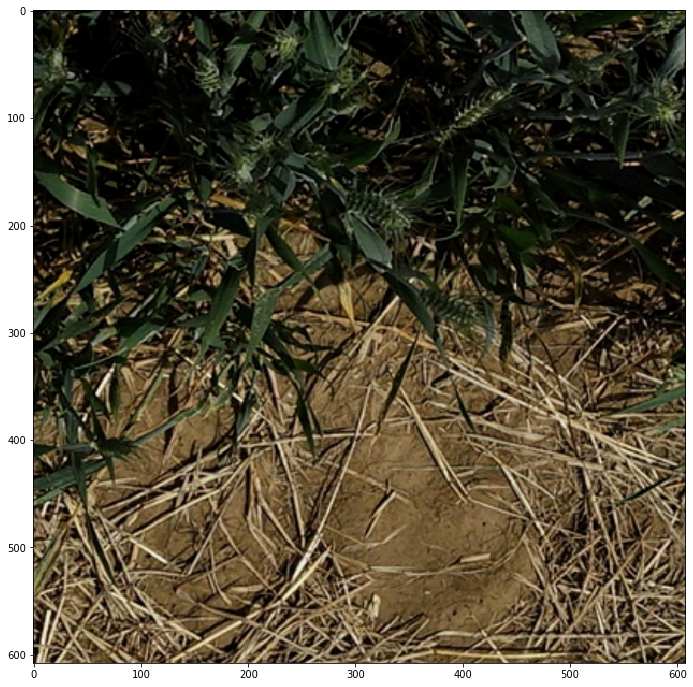

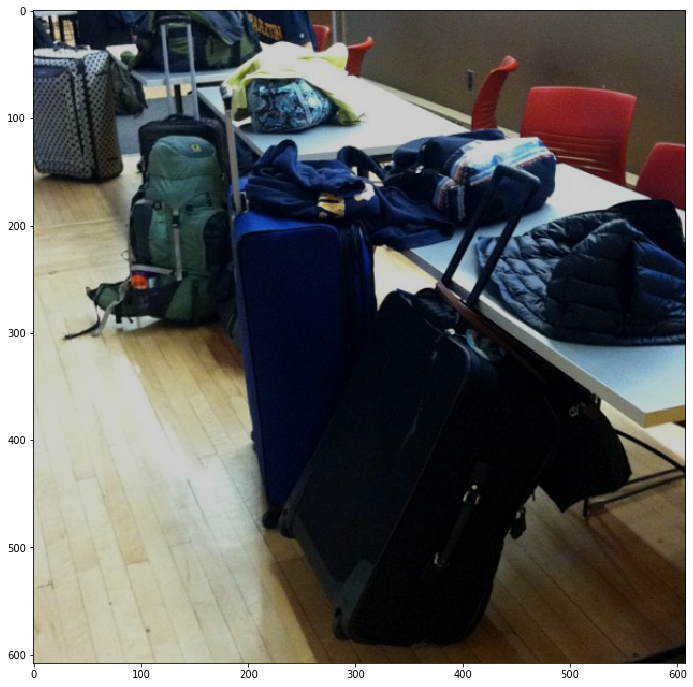

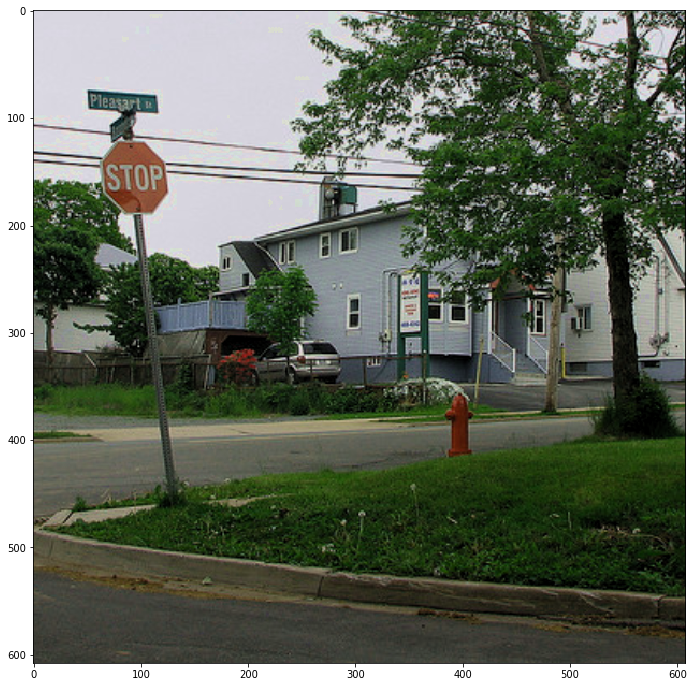

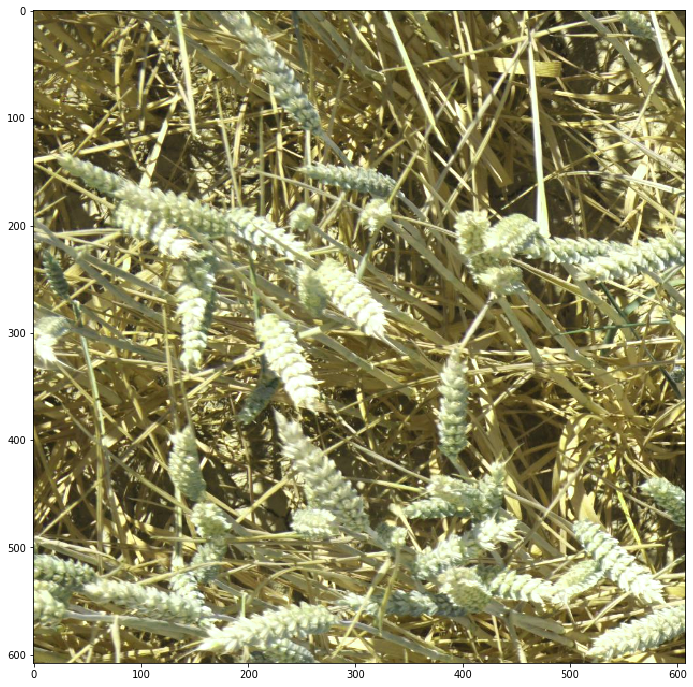

In [29]:
imgs, labels = next(iter(imgloader_val))
for i in range(len(imgs)):
    
    img = imgs[i,:,:,:].squeeze(0).numpy().transpose((1,2,0))
    mat = cv2.UMat(img)
    
    plt.figure(figsize=(12, 12))    
    plt.imshow(mat.get()) 
    print(labels[i])

## 2. Let's do some training

In [30]:
def validate(model, criterion, img_loader):
    
    running_corrects = 0
    running_loss = 0.0
    total_img = 0
    for j, (imgs, labels) in enumerate(imgloader):

        imgs = imgs.to(device)
        labels = labels.to(device)

        model.eval()
        with torch.set_grad_enabled(False): 
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)

            loss = criterion(outputs, labels)

        running_corrects += torch.sum(preds == labels)
        running_loss += loss.item() * imgs.size(0)
        total_img += imgs.size(0)

    avg_error = running_loss/total_img  
    accuracy = running_corrects.float()/total_img
    return avg_error, accuracy    

### Initialize with Darknet53's weights

In [31]:
cfgfile = "../cfg/darknet_feature_extractor.cfg"
weightfile = "../yolov3.weights"

extractor = dn.Darknet(cfgfile, inp_dim, weightfile)

Total number of lines in file: 555
tensor([       0,        2,        0, 32013312,        0], dtype=torch.int32)


In [32]:
extractor.add_extractor_layers()

In [33]:
m=extractor.to(device)

In [34]:
criterion = torch.nn.CrossEntropyLoss()

In [35]:
err, acc = validate(extractor, criterion, imgloader_val)
print(f"original: validation loss = {err}")
print(f"original: accuracy =  {acc}")

original: validation loss = 0.6955890874073875
original: accuracy =  0.4525231420993805


In [36]:
optimizer = optim.SGD(extractor.parameters(), lr=0.001, weight_decay = 0.0005, momentum=0.9)

# Decay LR by a factor of 0.1 every at 10th, 20th, 30,th
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[10,20,30], gamma=0.1)

In [37]:
num_epochs = 50

since = time.time()
for epoch in range(num_epochs):  # loop over the dataset multiple times
    print(f"Epoch {epoch}/{num_epochs-1}")
    print('-' * 10)
    
    #Training
    running_loss = 0.0
    total_img = 0
    for i, (imgs, labels) in enumerate(imgloader):
   
        imgs = imgs.to(device)
        labels = labels.to(device)
    
        # zero the parameter gradients
        optimizer.zero_grad()
    
        extractor.train()
        with torch.set_grad_enabled(True): #does not after nn.parameters
            outputs = extractor(imgs)
            
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
                  
        running_loss += loss.item() * imgs.size(0)
        total_img += imgs.size(0)
                    
    print(f"learning rate: {optimizer.param_groups[0]['lr']}")
    scheduler.step()
    
    epoch_loss = running_loss / total_img
    print(f"epoch {epoch}: training loss = {epoch_loss}")   
    
    err, acc = validate(extractor, criterion, imgloader_val)
    print(f"epoch {epoch}: validation loss = {err}")
    print(f"epoch {epoch}: accuracy =  {acc}")
    
    elapsed = time.time() - since
    print(f"time elapsed: {int(elapsed//60)}min {elapsed%60:1f}sec")
    
print('Finished Training')

Epoch 0/49
----------
learning rate: 0.001
epoch 0: training loss = 0.05443165990782339
epoch 0: validation loss = 0.003328968051940016
epoch 0: accuracy =  0.9994028210639954
time elapsed: 14min 18.919882sec
Epoch 1/49
----------
learning rate: 0.001
epoch 1: training loss = 0.008358732488803915
epoch 1: validation loss = 0.0027809852795944033
epoch 1: accuracy =  0.9995521306991577
time elapsed: 28min 31.695767sec
Epoch 2/49
----------
learning rate: 0.001
epoch 2: training loss = 0.004378762288604718
epoch 2: validation loss = 0.0018343419263739484
epoch 2: accuracy =  0.9997014403343201
time elapsed: 42min 49.864493sec
Epoch 3/49
----------
learning rate: 0.001
epoch 3: training loss = 0.002300183593817489
epoch 3: validation loss = 0.001370743864790722
epoch 3: accuracy =  0.9998506903648376
time elapsed: 57min 4.366339sec
Epoch 4/49
----------
learning rate: 0.001
epoch 4: training loss = 0.0020137152749412127
epoch 4: validation loss = 0.0019823713520100736
epoch 4: accuracy =  

In [38]:
torch.save(extractor.state_dict(), "wheatlo_extractor.pth")

## 3. Load model with trained weights and confirm accuracy

In [39]:
model = dn.Darknet(cfgfile, inp_dim)
model.add_extractor_layers()
model.load_state_dict(torch.load("wheatlo_extractor.pth"))

Total number of lines in file: 555


<All keys matched successfully>

In [40]:
err, acc = validate(model.cuda(), criterion, imgloader_val)
print(f"original: validation loss = {err}")
print(f"original: accuracy =  {acc}")

original: validation loss = 0.0004592958930073371
original: accuracy =  1.0
